In [3]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [4]:
def MultiMNISTcreate_imbalanced_datasets(
    root='data',
    download=True,
    batch_size=64,
    random_seed=42,
    fractions = [0.01, 0.02, 0.05, 0.1, 0.2],
):  
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    mnist_transform = transforms.ToTensor()
    Full_train_dataset = datasets.MNIST(root=root, train=True, transform=mnist_transform, download=download)
    train_data = Full_train_dataset.data
    train_labels = Full_train_dataset.targets
    train_index_label3 = (train_labels == 3)
    train_index_labels = (train_labels != 3)

    train_data_label3 = train_data[train_index_label3]
    train_data_labels = train_data[train_index_labels]
    train_labels_label3 = train_labels[train_index_label3]
    train_labels_labels = train_labels[train_index_labels]
    num_label3 = len(train_data_label3)
    num_labels = len(train_data_labels)
    print('Number of label 3:', num_label3)
    print('Number of other labels:', num_labels)

    train_datasets_dict = {}
    for fraction in fractions:
        num_label3_need = int(num_labels * fraction / 9)
        chosen_indices_label3 = np.random.choice(num_label3, num_label3_need, replace=False)
        subset_label3_data = train_data_label3[chosen_indices_label3]
        subset_label3_labels = train_labels_label3[chosen_indices_label3]

        new_train_data = torch.cat((train_data_labels, subset_label3_data), dim=0)
        new_train_labels = torch.cat((train_labels_labels, subset_label3_labels), dim=0)
        new_train_dataset = TensorDataset(new_train_data, new_train_labels)


        train_dataloader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
        train_datasets_dict[f'train_{fraction}'] = train_dataloader
    

    Full_test_dataset = datasets.MNIST(root=root, train=False, transform=mnist_transform, download=download)
    test_data  = Full_test_dataset.data
    test_labels = Full_test_dataset.targets
    test_dataset = TensorDataset(test_data, test_labels)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    data_loaders_dict = {**train_datasets_dict, **{'test': test_dataloader}}

    return data_loaders_dict

In [5]:
if __name__  == '__main__':
    MultiMNISTDataLoader = MultiMNISTcreate_imbalanced_datasets(
        root = '/Users/max/MasterThesisData/MNIST',
        download = True,
        batch_size = 64,
        random_seed=42,
        fractions = [0.01, 0.02, 0.05, 0.1, 0.2],
    )
    MNIST_train_loader001 = MultiMNISTDataLoader['train_0.01']
    MNIST_train_loader002 = MultiMNISTDataLoader['train_0.02']
    MNIST_train_loader005 = MultiMNISTDataLoader['train_0.05']
    MNIST_train_loader010 = MultiMNISTDataLoader['train_0.1']
    MNIST_train_loader020 = MultiMNISTDataLoader['train_0.2']
    MNIST_test_loader = MultiMNISTDataLoader['test']

    print('Number of batches in MNIST_train_loader001:', len(MNIST_train_loader001))
    print('Number of batches in MNIST_train_loader002:', len(MNIST_train_loader002))
    print('Number of batches in MNIST_train_loader005:', len(MNIST_train_loader005))
    print('Number of batches in MNIST_train_loader010:', len(MNIST_train_loader010))
    print('Number of batches in MNIST_train_loader020:', len(MNIST_train_loader020))
    print('Number of batches in MNIST_test_loader:', len(MNIST_test_loader))
    print('Number of images in MNIST_train_loader001:', len(MNIST_train_loader001.dataset))
    print('Number of images in MNIST_train_loader002:', len(MNIST_train_loader002.dataset))
    print('Number of images in MNIST_train_loader005:', len(MNIST_train_loader005.dataset))
    print('Number of images in MNIST_train_loader010:', len(MNIST_train_loader010.dataset))
    print('Number of images in MNIST_train_loader020:', len(MNIST_train_loader020.dataset))
    print('Number of images in MNIST_test_loader:', len(MNIST_test_loader.dataset))

Number of label 3: 6131
Number of other labels: 53869
Number of batches in MNIST_train_loader001: 843
Number of batches in MNIST_train_loader002: 844
Number of batches in MNIST_train_loader005: 847
Number of batches in MNIST_train_loader010: 852
Number of batches in MNIST_train_loader020: 861
Number of batches in MNIST_test_loader: 157
Number of images in MNIST_train_loader001: 53928
Number of images in MNIST_train_loader002: 53988
Number of images in MNIST_train_loader005: 54168
Number of images in MNIST_train_loader010: 54467
Number of images in MNIST_train_loader020: 55066
Number of images in MNIST_test_loader: 10000


In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def Multi_get_class_distirbution(data_loader):
    class_distribution = {}
    for i, (data, target) in enumerate(data_loader):
        for label in target:
            label = label.item()
            if label in class_distribution:
                class_distribution[label] += 1
            else:
                class_distribution[label] = 1
    return class_distribution

In [7]:
class_distribution_train001 = Multi_get_class_distirbution(MNIST_train_loader001)
class_distribution_train002 = Multi_get_class_distirbution(MNIST_train_loader002)
class_distribution_train005 = Multi_get_class_distirbution(MNIST_train_loader005)
class_distribution_train010 = Multi_get_class_distirbution(MNIST_train_loader010)
class_distribution_train020 = Multi_get_class_distirbution(MNIST_train_loader020)
class_distribution_test = Multi_get_class_distirbution(MNIST_test_loader)

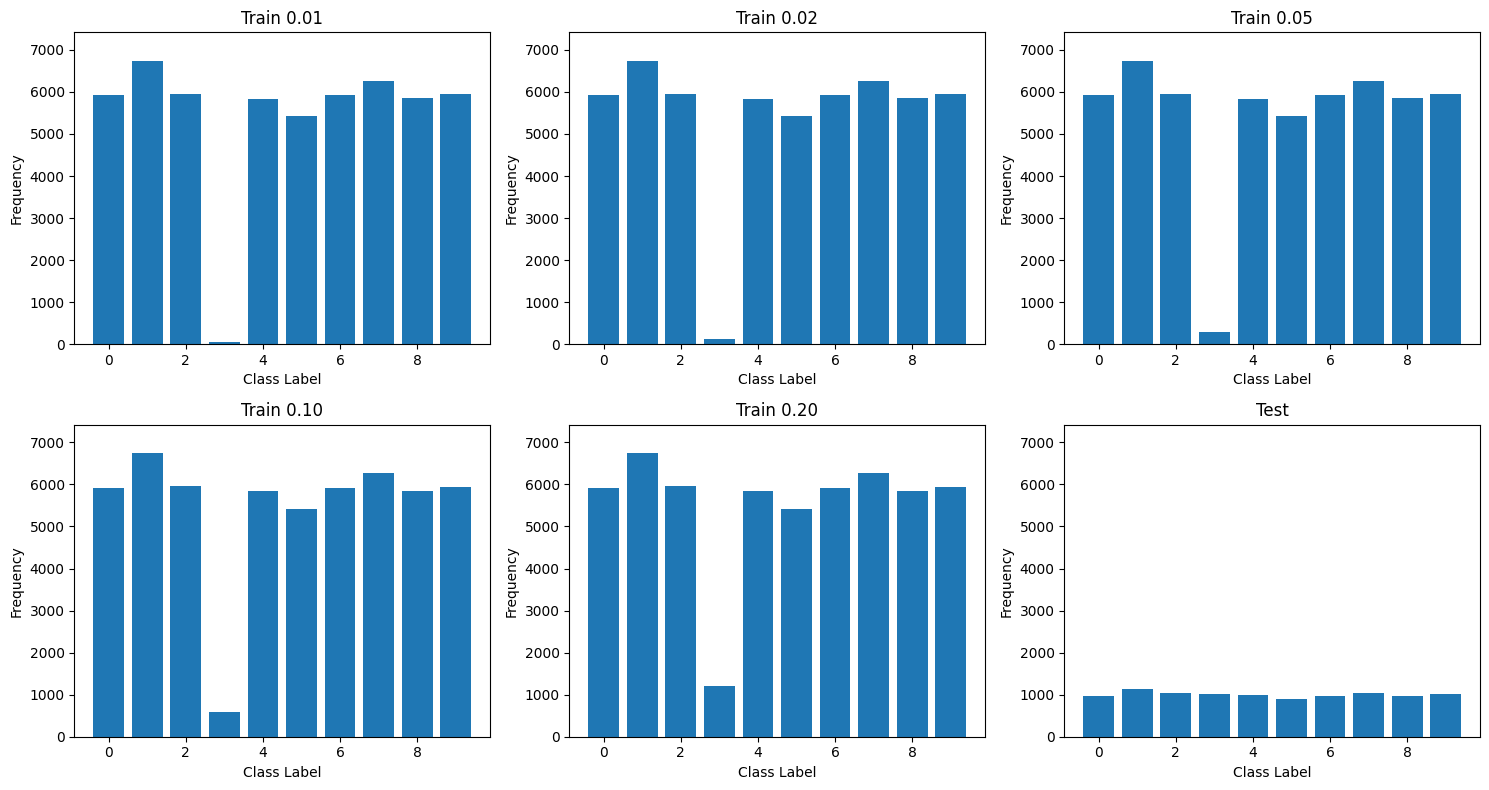

In [8]:
import matplotlib.pyplot as plt


dists = [
    (class_distribution_train001, 'Train 0.01'),
    (class_distribution_train002, 'Train 0.02'),
    (class_distribution_train005, 'Train 0.05'),
    (class_distribution_train010, 'Train 0.10'),
    (class_distribution_train020, 'Train 0.20'),
    (class_distribution_test,    'Test')
]


fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()  


max_count = max([max(dist_dict.values()) for dist_dict, _ in dists])

for ax, (dist_dict, title) in zip(axes, dists):
    
    ax.bar(dist_dict.keys(), dist_dict.values())
    ax.set_title(title)
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Frequency')
    
    ax.set_ylim([0, max_count * 1.1]) 

plt.tight_layout()
plt.show()